In [56]:
from pathlib import Path
import pandas as pd
from biom import load_table

CLASSES = ["agricultural", "desert", "forest", "grassland", "tropical_rainforest"]
INPUT_ROOT = Path("biom_data")

dfs = []
info = []

for label in CLASSES:
    folder = INPUT_ROOT / label
    if not folder.exists():
        continue

    for biom_path in sorted(folder.glob("*.biom")):
        table = load_table(str(biom_path))
        df = table.to_dataframe(dense=True)
        df.index = df.index.astype(str)
        df.columns = df.columns.astype(str)

        orig_samples = df.columns.tolist()
        rename_map = {s: f"{label}:{biom_path.stem}:{s}" for s in orig_samples}
        df = df.rename(columns=rename_map)

        dfs.append(df)
        info.append({
            "class": label,
            "file": biom_path.name,
            "file_stem": biom_path.stem,
            "n_obs": df.shape[0],
            "n_samples": len(orig_samples),
        })

all_data = pd.concat(dfs, axis=0, ignore_index=False)

summary = pd.DataFrame(info)
total_expected = int(summary["n_samples"].sum())
all_sample_cols = [c for c in all_data.columns]
print(f"Ожидаемых сэмплов (сумма по файлам): {total_expected}")
print(f"Фактических уникальных сэмплов в матрице: {len(all_sample_cols)}")
print(f"Файлов: {len(summary)}")
summary.head()


Ожидаемых сэмплов (сумма по файлам): 498
Фактических уникальных сэмплов в матрице: 498
Файлов: 498


,class,file,file_stem,n_obs,n_samples
0,agricultural,agricultural_1.biom,agricultural_1,274,1
1,agricultural,agricultural_10.biom,agricultural_10,10,1
2,agricultural,agricultural_100.biom,agricultural_100,686,1
3,agricultural,agricultural_11.biom,agricultural_11,19,1
4,agricultural,agricultural_12.biom,agricultural_12,313,1


Всего сэмплов: 498
Классы (до фильтра): {'agricultural': 100, 'forest': 100, 'grassland': 100, 'tropical_rainforest': 100, 'desert': 98}
CAP-фич (без утечки): 500  | фильтр по prevalence>=0.1, mean>=1e-06
Удалено сэмплов: 74 (все нули по CAP: 74, без метки: 0)
Осталось сэмплов: 424
Классы (после фильтра): {'agricultural': 100, 'grassland': 100, 'tropical_rainforest': 100, 'forest': 69, 'desert': 55}
Признаков в модели (train-only FS): 100


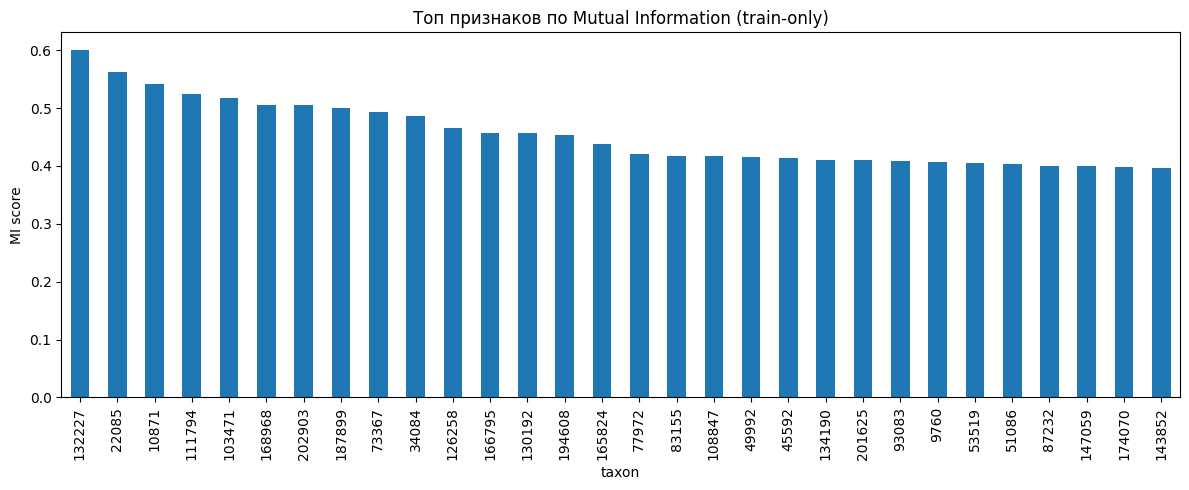

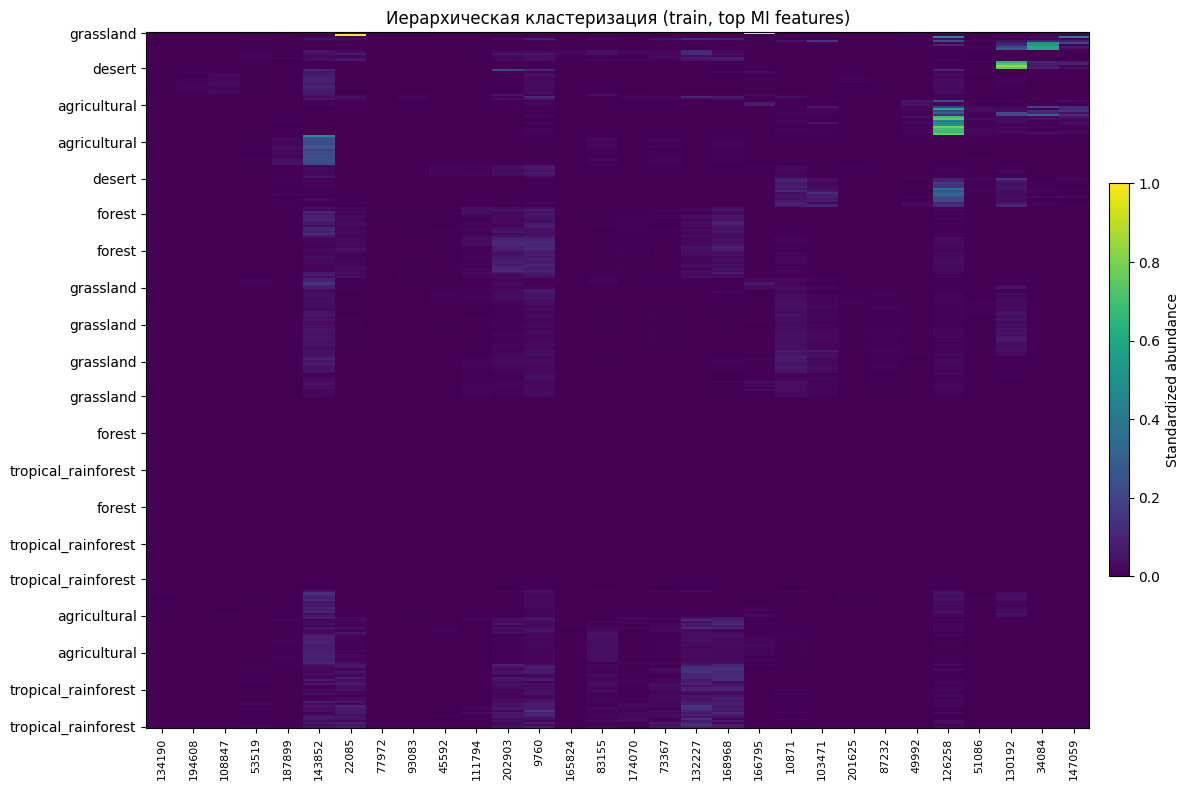

In [57]:
# === Подготовка данных и фильтрация пустых сэмплов ===
# Честный отбор признаков (без утечки) + визуализации по train
# Ожидается, что all_data уже собран, а имена столбцов имеют формат "<class>:<file_stem>:<orig_sample>"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, leaves_list

# --- параметры отбора ---
CAP_MAX_FEATURES = 500        # верхняя рамка признаков (без меток), честная
PREVALENCE_MIN   = 0.10       # таксон встречается хотя бы в 10% сэмплов
MEAN_ABUND_MIN   = 1e-6       # минимальная средняя относительная доля
K_MODEL_FEATURES = 100        # число признаков для модели, отбираемых ТОЛЬКО на трейне

# --- подготовка таблиц ---
samples = pd.Index(all_data.columns, name="sample")
sample_to_class = samples.to_series().str.split(":", n=1, expand=True)[0]
sample_to_class.name = "class"
classes = sorted(sample_to_class.unique().tolist())

tmp = all_data.reset_index().rename(columns={all_data.index.name or "index": "taxon"})
long = tmp.melt(id_vars=["taxon"], var_name="sample", value_name="abundance")
long = long[long["abundance"] > 0]
long = long.merge(sample_to_class.reset_index().rename(columns={"index": "sample"}), on="sample", how="left")

tot = long.groupby("sample", as_index=False)["abundance"].sum().rename(columns={"abundance": "tot"})
long = long.merge(tot, on="sample", how="left")
long["rel_abundance"] = long["abundance"] / long["tot"]

wide_rel = long.pivot_table(index="sample", columns="taxon", values="rel_abundance", aggfunc="sum").fillna(0)
y_full = sample_to_class.reindex(wide_rel.index)

# --- честный CAP по признакам (без использования y) ---
prevalence = (wide_rel > 0).mean(axis=0)
mean_abund = wide_rel.mean(axis=0)

cap_mask = (prevalence >= PREVALENCE_MIN) & (mean_abund >= MEAN_ABUND_MIN)
cap_candidates = mean_abund[cap_mask].sort_values(ascending=False)
cap_features = cap_candidates.head(CAP_MAX_FEATURES).index.tolist()

X_cap = wide_rel.reindex(columns=cap_features).fillna(0)

# фильтруем пустые сэмплы и NaN-метки
zero_mask = (X_cap > 0).sum(axis=1) == 0
nan_mask  = y_full.isna()
keep_mask = ~(zero_mask | nan_mask)
X_cap = X_cap.loc[keep_mask]
y_cap = y_full.loc[keep_mask]

print(f"Всего сэмплов: {len(wide_rel)}")
print(f"Классы (до фильтра): {y_full.value_counts().to_dict()}")
print(f"CAP-фич (без утечки): {len(cap_features)}  | фильтр по prevalence>={PREVALENCE_MIN}, mean>={MEAN_ABUND_MIN}")
print(f"Удалено сэмплов: {int((~keep_mask).sum())} (все нули по CAP: {int(zero_mask.sum())}, без метки: {int(nan_mask.sum())})")
print(f"Осталось сэмплов: {len(X_cap)}")
print(f"Классы (после фильтра): {y_cap.value_counts().to_dict()}")

# --- честный train/test сплит ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_cap, y_cap))
X_tr, X_te = X_cap.iloc[train_idx], X_cap.iloc[test_idx]
y_tr, y_te = y_cap.iloc[train_idx], y_cap.iloc[test_idx]

# --- отбор признаков ТОЛЬКО на трейне ---
selector = SelectKBest(score_func=mutual_info_classif, k=min(K_MODEL_FEATURES, X_tr.shape[1]))
selector.fit(X_tr.values, y_tr.values)
mi_scores = pd.Series(selector.scores_, index=X_tr.columns).fillna(0).sort_values(ascending=False)
model_features = mi_scores.head(selector.k).index.tolist()

X_tr_sel = X_tr[model_features].copy()
X_te_sel = X_te[model_features].copy()

print(f"Признаков в модели (train-only FS): {len(model_features)}")

# --- ВИЗУАЛИЗАЦИИ (по train, чтобы без утечки) ---

# 1) Гистограмма: топ-30 признаков по MI на трейне
top_k_plot = min(30, len(mi_scores))
top_mi = mi_scores.head(top_k_plot)

plt.figure(figsize=(12, 5))
top_mi.plot(kind="bar")
plt.title("Топ признаков по Mutual Information (train-only)")
plt.ylabel("MI score")
plt.tight_layout()
plt.show()

# 2) Иерархическая кластеризация heatmap по train и top-30 фичам модели
heat_feats = model_features[:top_k_plot]
X_heat = X_tr_sel[heat_feats].copy()

Z = StandardScaler().fit_transform(X_heat.values)

row_link = linkage(Z, method="average", metric="euclidean")
col_link = linkage(Z.T, method="average", metric="euclidean")

row_order = leaves_list(row_link)
col_order = leaves_list(col_link)

X_ord = X_heat.iloc[row_order, :].iloc[:, col_order]
y_ord = y_tr.iloc[row_order]

plt.figure(figsize=(12, 8))
im = plt.imshow(X_ord.values, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.02, pad=0.02, label="Standardized abundance")
plt.yticks(
    np.linspace(0, len(X_ord)-1, num=min(20, len(X_ord)), dtype=int),
    y_ord.iloc[np.linspace(0, len(X_ord)-1, num=min(20, len(X_ord)), dtype=int)].values
)
plt.xticks(np.arange(len(X_ord.columns)), X_ord.columns, rotation=90, fontsize=8)
plt.title("Иерархическая кластеризация (train, top MI features)")
plt.tight_layout()
plt.show()






До балансировки (train): {'desert': 47, 'agricultural': 80, 'tropical_rainforest': 80, 'grassland': 75, 'forest': 50}


C:\Users\HONOR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


После балансировки (train): {'desert': 80, 'agricultural': 80, 'tropical_rainforest': 80, 'grassland': 80, 'forest': 80}

=== Сводка по моделям (сортировка по F1) ===
               Accuracy  Precision    Recall        F1
Model                                                 
GradientBoost  0.915663   0.920000  0.913504  0.910712
LogReg         0.903614   0.908635  0.908889  0.902638
RandomForest   0.903614   0.910476  0.903504  0.900436
SVM            0.843373   0.898263  0.840513  0.850560
KNN            0.771084   0.803341  0.794615  0.768037


<Figure size 1000x600 with 0 Axes>

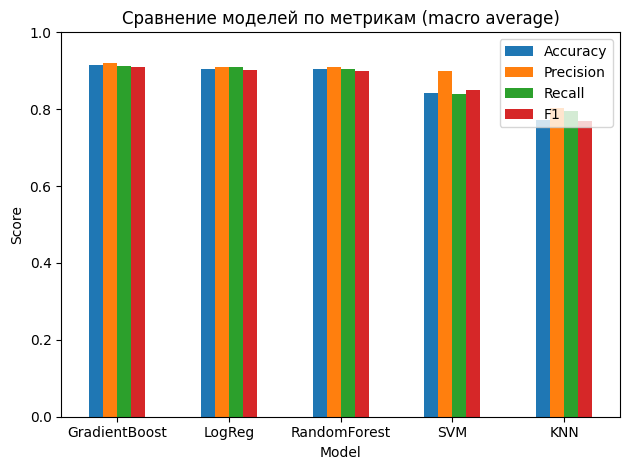


Лучшая модель по F1: GradientBoost (0.911)

Отчёты по классам (лучшие топ-3):

=== GradientBoost ===
                     precision    recall  f1-score   support

       agricultural       1.00      0.95      0.97        20
             desert       1.00      0.92      0.96        12
             forest       0.67      0.92      0.77        13
          grassland       0.93      0.78      0.85        18
tropical_rainforest       1.00      1.00      1.00        20

           accuracy                           0.92        83
          macro avg       0.92      0.91      0.91        83
       weighted avg       0.93      0.92      0.92        83

=== LogReg ===
                     precision    recall  f1-score   support

       agricultural       0.87      1.00      0.93        20
             desert       0.92      0.92      0.92        12
             forest       0.81      1.00      0.90        13
          grassland       1.00      0.78      0.88        18
tropical_rainforest      

In [58]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False

X_use = X_intersect.fillna(0)
y_use = y.loc[X_use.index]
counts = y_use.value_counts()
ok = counts[counts >= 2].index
X_use = X_use[y_use.isin(ok)]
y_use = y_use[y_use.isin(ok)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_use, y_use))
X_train, X_test = X_use.iloc[train_idx], X_use.iloc[test_idx]
y_train_str, y_test_str = y_use.iloc[train_idx], y_use.iloc[test_idx]

le = LabelEncoder()
y_train = le.fit_transform(y_train_str)
y_test  = le.transform(y_test_str)

print("До балансировки (train):", dict(Counter(y_train_str)))

ros = RandomOverSampler(random_state=42)

models = {
    "LogReg": LogisticRegression(max_iter=5000, solver="lbfgs", multi_class="auto"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1, eval_metric="mlogloss"
    ) if has_xgb else GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
}

results = []
reports_text = {}

for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ("ros", ros),
        ("scaler", StandardScaler()),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred_enc = pipe.predict(X_test)
    y_pred_str = le.inverse_transform(y_pred_enc)

    if name == "LogReg":
        y_bal = pipe.named_steps["ros"].fit_resample(X_train, y_train)[1]
        print("После балансировки (train):", dict(Counter(le.inverse_transform(y_bal))))

    acc = accuracy_score(y_test, y_pred_enc)
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_test, y_pred_enc, average="macro", zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": p_mac,
        "Recall": r_mac,
        "F1": f1_mac
    })

    reports_text[name] = classification_report(y_test_str, y_pred_str, zero_division=0, output_dict=False)

df_res = pd.DataFrame(results).set_index("Model").sort_values("F1", ascending=False)
print("\n=== Сводка по моделям (сортировка по F1) ===")
print(df_res)

plt.figure(figsize=(10,6))
df_res.plot(kind="bar")
plt.title("Сравнение моделей по метрикам (macro average)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

best_model = df_res["F1"].idxmax()
print(f"\nЛучшая модель по F1: {best_model} ({df_res.loc[best_model,'F1']:.3f})\n")
print("Отчёты по классам (лучшие топ-3):\n")
for name in df_res.head(3).index:
    print(f"=== {name} ===")
    print(reports_text[name])





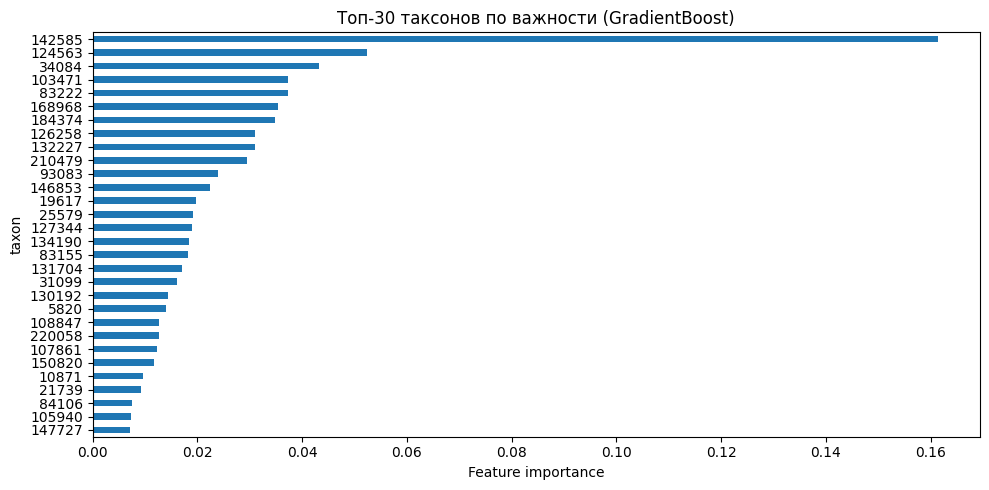

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

model = pipe.named_steps["clf"]
feat_names = X_train.columns

try:
    importances = model.feature_importances_
except AttributeError:
    from sklearn.inspection import permutation_importance
    importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42).importances_mean

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(30).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Топ-30 таксонов по важности (GradientBoost)")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()



In [60]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from imblearn.over_sampling import RandomOverSampler

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

X_use = X_intersect.fillna(0)
y_use = y.loc[X_use.index]
ok = y_use.value_counts()
ok = ok[ok >= 2].index
X_use = X_use[y_use.isin(ok)]
y_use = y_use[y_use.isin(ok)]

sss_outer = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss_outer.split(X_use, y_use))
X_tr_full, X_te = X_use.iloc[train_idx], X_use.iloc[test_idx]
y_tr_full_str, y_te_str = y_use.iloc[train_idx], y_use.iloc[test_idx]

le = LabelEncoder()
y_tr_full = pd.Series(le.fit_transform(y_tr_full_str), index=y_tr_full_str.index, name="y")
y_te_enc = pd.Series(le.transform(y_te_str), index=y_te_str.index, name="y")
classes_ = le.classes_
n_classes = len(classes_)

sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
tr_idx, va_idx = next(sss_inner.split(X_tr_full, y_tr_full))
X_tr, X_va = X_tr_full.iloc[tr_idx], X_tr_full.iloc[va_idx]
y_tr_str, y_va_str = y_tr_full_str.iloc[tr_idx], y_tr_full_str.iloc[va_idx]
y_tr = y_tr_full.iloc[tr_idx]
y_va = y_tr_full.iloc[va_idx]

forest_label = np.where(classes_ == "forest")[0][0] if "forest" in classes_ else None

base_k = min(300, X_tr.shape[1])
mi_multi = pd.Series(mutual_info_classif(X_tr.values, y_tr.values, random_state=42), index=X_tr.columns).fillna(0).sort_values(ascending=False)
base_feats = mi_multi.head(base_k).index.tolist()

forest_feats = []
if forest_label is not None:
    y_tr_bin = (y_tr.values == forest_label).astype(int)
    mi_forest = pd.Series(mutual_info_classif(X_tr.values, y_tr_bin, random_state=42), index=X_tr.columns).fillna(0).sort_values(ascending=False)
    forest_feats = mi_forest.head(min(60, X_tr.shape[1])).index.tolist()

selected = []
for f in base_feats + forest_feats:
    if f not in selected:
        selected.append(f)
selected = selected[:min(300, len(selected))]

X_tr = X_tr[selected].copy()
X_va = X_va[selected].copy()
X_te_sel = X_te[selected].copy()

removed_outliers = 0
if forest_label is not None:
    mask_forest = (y_tr == forest_label)
    if mask_forest.sum() > 5:
        rate = min(0.08, max(0.02, 10 / mask_forest.sum()))
        iso = IsolationForest(contamination=rate, random_state=42)
        pred = iso.fit_predict(X_tr.loc[mask_forest])
        drop_idx = X_tr.loc[mask_forest].index[pred == -1]
        removed_outliers = len(drop_idx)
        keep_idx = X_tr.index.difference(drop_idx)
        X_tr = X_tr.loc[keep_idx]
        y_tr = y_tr.loc[keep_idx]
        y_tr_str = y_tr_str.loc[keep_idx]

cnt = Counter(y_tr.values)
max_count = max(cnt.values()) if cnt else 0
sampling_strategy = {}
for cls_id, c in cnt.items():
    target = max_count
    if forest_label is not None and cls_id == forest_label:
        target = int(np.ceil(max_count * 1.3))
    sampling_strategy[cls_id] = max(target, c)

ros = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy)
X_bal, y_bal = ros.fit_resample(X_tr, y_tr.values)

if HAS_XGB:
    unique, counts_bal = np.unique(y_bal, return_counts=True)
    inv_freq = {c: max(counts_bal) / cnt for c, cnt in zip(unique, counts_bal)}
    if forest_label is not None and forest_label in inv_freq:
        inv_freq[forest_label] *= 1.4
    sample_weight = np.array([inv_freq[c] for c in y_bal], dtype=float)

    model = XGBClassifier(
        n_estimators=700,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        objective="multi:softprob",
        eval_metric="mlogloss"
    )
    model.fit(X_bal, y_bal, sample_weight=sample_weight)
else:
    model = GradientBoostingClassifier(n_estimators=600, learning_rate=0.05, max_depth=3, random_state=42)
    model.fit(X_bal, y_bal)

proba_va = model.predict_proba(X_va)
proba_te = model.predict_proba(X_te_sel)

thresholds = np.full(n_classes, 1.0 / n_classes)
for k in range(n_classes):
    y_true = (y_va.values == k).astype(int)
    scores = proba_va[:, k]
    uniq = np.unique(scores)
    if len(uniq) > 100:
        qs = np.quantile(scores, np.linspace(0.1, 0.9, 81))
        cand = np.unique(qs)
    else:
        cand = uniq
    best_t, best_f1 = 0.5, -1
    for t in cand:
        y_hat = (scores >= t).astype(int)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    thresholds[k] = best_t

scores_te = proba_te.copy()
pred_te = np.array([np.argmax(row - thresholds + thresholds.mean()) for row in scores_te])

acc = accuracy_score(y_te_enc.values, pred_te)
p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(y_te_enc.values, pred_te, average="macro", zero_division=0)

print("До балансировки (train):", dict(Counter(y_tr_str)))
print("Удалено выбросов forest:", removed_outliers)
print("После балансировки (train):", dict(Counter(le.inverse_transform(y_bal))))
print("Выбрано признаков:", len(selected))
print("Пороги по классам:", {cls: float(f"{thr:.3f}") for cls, thr in zip(classes_, thresholds)})

print("\n=== Результаты на тесте ===")
print(f"Тренировочных образцов: {len(X_tr)}")
print(f"Валидационных образцов: {len(X_va)}")
print(f"Тестовых образцов: {len(X_te_sel)}")
print(f"Accuracy: {acc:.3f}")
print(f"Precision (macro): {p_mac:.3f}")
print(f"Recall (macro): {r_mac:.3f}")
print(f"F1 (macro): {f1_mac:.3f}\n")

print("Отчёт по классам:\n")
print(classification_report(le.inverse_transform(y_te_enc.values), le.inverse_transform(pred_te), zero_division=0, output_dict=False))





До балансировки (train): {'agricultural': 60, 'desert': 35, 'forest': 35, 'grassland': 56, 'tropical_rainforest': 60}
Удалено выбросов forest: 3
После балансировки (train): {'agricultural': 60, 'desert': 60, 'forest': 78, 'grassland': 60, 'tropical_rainforest': 60}
Выбрано признаков: 300
Пороги по классам: {'agricultural': 0.417, 'desert': 0.794, 'forest': 0.456, 'grassland': 0.177, 'tropical_rainforest': 0.563}

=== Результаты на тесте ===
Тренировочных образцов: 246
Валидационных образцов: 83
Тестовых образцов: 83
Accuracy: 0.904
Precision (macro): 0.913
Recall (macro): 0.897
F1 (macro): 0.896

Отчёт по классам:

                     precision    recall  f1-score   support

       agricultural       1.00      0.95      0.97        20
             desert       1.00      0.83      0.91        12
             forest       0.63      0.92      0.75        13
          grassland       0.93      0.78      0.85        18
tropical_rainforest       1.00      1.00      1.00        20

         